In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from skimage import io
from skimage import img_as_ubyte
import cv2 as cv
from skimage import exposure
import glob
import os
import seaborn as sns
from skimage.filters import sobel
from skimage.measure import shannon_entropy
from sklearn import preprocessing
import lightgbm as lgb
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import random

In [2]:
PATCH_SIZE = 35

# Adding the image and convert it into grey color image:-
img = cv.imread('mt_everst.jpg',2)
re_img = cv.resize(img,(1700,1700))
cv.imshow('Mountain Resize',re_img)
cv.waitKey(0)
cv.destroyAllWindows()
cv.waitKey(1)

2024-03-18 11:36:12.459 Python[2065:38382] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


-1

In [3]:
GLCM = graycomatrix(img,[1],[0,np.pi/4,np.pi/2,3*np.pi/4])
a = graycoprops(GLCM,'energy')[0,0]
a

0.03595763856226541

In [ ]:
cell_location = [(100,100),(850,850),(670,850),(1600,850)]
cell_patches = []
for loc in cell_location:
    cell_patches.append(re_img[loc[0]:loc[0] + PATCH_SIZE,loc[1]:loc[1] + PATCH_SIZE])
    patch_rescaled = exposure.rescale_intensity(patch, in_range='re_img', out_range=(0, 1))
    cell_patches.append(patch_rescaled)

In [ ]:
# scratch_locations = [

### Compute GLCM

In [8]:
dis_simm = []
corr = []
homogen = []
energy = []
contrast = []

for patch in (cell_patches):
    patch_uint8 = img_as_ubyte(patch)
    glcm = graycomatrix(patch_uint8, distances=[5], angles=[0], levels=256,symmetric=True, normed=True)
    dis_simm.append(graycoprops(glcm, 'dissimilarity')[0, 0]) #[0,0] to convert array to value
    corr.append(graycoprops(glcm, 'correlation')[0, 0])
    homogen.append(graycoprops(glcm, 'homogeneity')[0, 0])
    energy.append(graycoprops(glcm, 'energy')[0, 0])
    contrast.append(graycoprops(glcm, 'contrast')[0, 0])

(-0.5, 4999.5, 3337.5, -0.5)

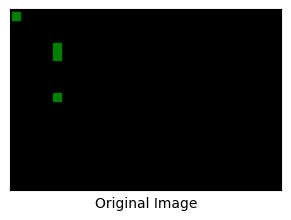

In [77]:
fig = plt.figure(figsize=(8, 8))

# display original image with locations of patches
ax = fig.add_subplot(3, 2, 1)
ax.imshow(image, cmap=plt.cm.gray,
          vmin=0, vmax=255)
for (y, x) in cell_location:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'gs')
ax.set_xlabel('Original Image')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('image')

In [76]:
ax = fig.add_subplot(3, 2, 2)
ax.plot(dis_simm[:len(cell_patches)], corr[:len(cell_patches)], 'go',
        label='Cells')
ax.plot(dis_simm[len(cell_patches):], corr[len(cell_patches):], 'bo',
        label='Scratch')
ax.set_xlabel('GLCM Dissimilarity')
ax.set_ylabel('GLCM Correlation')
ax.legend()

# display the image patches
for i, patch in enumerate(cell_patches):
    ax = fig.add_subplot(3, len(cell_patches), len(cell_patches)*1 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray,
              vmin=0, vmax=255)
    ax.set_xlabel('Cells %d' % (i + 1))


# display the patches and plot
fig.suptitle('Grey level co-occurrence matrix features', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

### GLCM on large dataset

In [56]:
print(os.listdir("image/"))

['.DS_Store', 'train', 'validation']


In [57]:
SIZE = 128

# Setup train list:-
train_img = []
train_labels = []

for directory_path in glob.glob("image/train/*"):
    label = os.path.basename(directory_path)
    print(label)
    for image_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print(image_path)
        img = cv.imread(image_path, 0)
        if img is None:
            print("Error: Unable to read image at path:", image_path)
            continue
        if img.size == 0:
            print("Error: Empty image at path:", image_path)
            continue
        img = cv.resize(img, (SIZE, SIZE))
        train_img.append(img)
        train_labels.append(label)

train_img = np.array(train_img)
train_labels = np.array(train_labels)

sunrise
image/train/sunrise/R97U8MJI3D4J.jpg
image/train/sunrise/sunrise44_jpg.rf.fef99096ac65566c057479b257973d32.jpg
image/train/sunrise/sunrise334_jpg.rf.0aacd9f7c17271e3cb60584350f1a27a.jpg
image/train/sunrise/sunrise323_jpg.rf.e04f70c7d2860c0f1ea01d88551d2ca4.jpg
image/train/sunrise/sunrise33.jpg
image/train/sunrise/sunrise27.jpg
image/train/sunrise/shine22.jpg
image/train/sunrise/shine36.jpg
image/train/sunrise/sunrise250_jpg.rf.7eec41084afc610f24838fcd55a1431d.jpg
image/train/sunrise/A1QNVBQSG7EV.jpg
image/train/sunrise/sunrise233_jpg.rf.84f0cd891f4119e732d7a2f734c51348.jpg
image/train/sunrise/sunrise203.jpg
image/train/sunrise/sunrise217.jpg
image/train/sunrise/H92O69MVE45W.jpg
image/train/sunrise/THV37KNFLZOS.jpg
image/train/sunrise/sunrise91_jpg.rf.0e1b1808f3437297d0e7f32c39c6a536.jpg
image/train/sunrise/sunrise159_jpg.rf.b27847514600207731d346a37864a1d6.jpg
image/train/sunrise/sunrise49_jpg.rf.97520df0d717670ef1ea0706abb1a365.jpg
image/train/sunrise/20R40BNNTIL8.jpg
image/tr

In [58]:
len(train_labels)

4254

In [6]:
test_img = []
test_labels = []

for directory_path in glob.glob("image/validation/*"):
    label = os.path.basename(directory_path)
    print(label)
    for image_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print(image_path)
        img = cv.imread(image_path, 0)
        if img is None:
            print("Error: Unable to read image at path:", image_path)
            continue
        if img.size == 0:
            print("Error: Empty image at path:", image_path)
            continue
        img = cv.resize(img, (SIZE, SIZE))
        test_img.append(img)
        test_labels.append(label)

test_img = np.array(test_img)
test_labels = np.array(test_labels)

sunrise
image/validation/sunrise/P7O4QILDPWAT.jpg
image/validation/sunrise/EGZAEVVLFH1E.jpg
image/validation/sunrise/CN6LAO8FLP2L.jpg
image/validation/sunrise/8QEGDMI01W2C.jpg
image/validation/sunrise/IWT6T82QCKS4.jpg
image/validation/sunrise/KIJPBZCSI3GK.jpg
image/validation/sunrise/NWY4L28MM8I3.jpg
image/validation/sunrise/MZ9D5PKWSKW2.jpg
image/validation/sunrise/1C9ZGKBFZCZK.jpg
image/validation/sunrise/1V0J0IQ3DT7H.jpg
image/validation/sunrise/MVPPQBTWTHWD.jpg
image/validation/sunrise/7AWDI37S27QR.jpg
image/validation/sunrise/WOAP8U1DIJE3.jpg
image/validation/sunrise/SMI1UGGMHVCE.jpg
image/validation/sunrise/433YKT7E9NF3.jpg
image/validation/sunrise/VMKADDXUHMKX.jpg
image/validation/sunrise/OVBRC7RLENN8.jpg
image/validation/sunrise/OL2JXZ39WPI9.jpg
image/validation/sunrise/F6Q02Q6QH4MT.jpg
image/validation/sunrise/EHJMYQPUIVD2.jpg
image/validation/sunrise/YAEBE3VW30WW.jpg
image/validation/sunrise/N1MOPPUBLQYF.jpg
image/validation/sunrise/QAHTSQ16BUW6.jpg
image/validation/sunrise/X

In [7]:
len(test_img)

136

In [59]:
from sklearn import preprocessing

In [60]:
# lable the labels with integers from texts

le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [61]:
# assign the train test split data

x_train, y_train, x_test, y_test = train_img,train_labels_encoded,test_img,test_labels_encoded

# normlise the value b/w [0,1]
x_train,x_test = x_train/255.0,x_test/255.0

In [62]:
def feature_extractor(dataset):
    img_dataset = pd.DataFrame()
    for images in range(dataset.shape[0]):
        df = pd.DataFrame()
        img = dataset[images,:,:]
        angles = [0, np.pi/4, np.pi/2]
        distances = [1, 3, 5]
        properties = ['energy', 'correlation', 'dissimilarity', 'homogeneity', 'contrast']
        image_dataset = pd.DataFrame()
        img_uint8 = (img * 255).astype(np.uint8)
        for i, distance in enumerate(distances):
            for j, angle in enumerate(angles):
                GLCM = graycomatrix(img_uint8, [distance], [angle], levels=256, symmetric=True, normed=True)
                for prop in properties:
                    prop_value = graycoprops(GLCM, prop)[0]
                    # Check for NaN values and handle them by replacing with 0
                    if np.isnan(prop_value):
                        prop_value = 0
                    df[f'{prop}_{i}_{j}'] = prop_value
        # Move the concatenation outside the inner loop
        image_dataset = pd.concat([image_dataset, df], ignore_index=True)
        img_dataset = pd.concat([img_dataset, image_dataset], ignore_index=True)
    return img_dataset


In [63]:
image_feature = feature_extractor(x_train)

In [64]:
 print(image_feature.shape)

(4254, 45)


In [65]:
image_feature.head()

,energy_0_0,correlation_0_0,dissimilarity_0_0,homogeneity_0_0,contrast_0_0,energy_0_1,correlation_0_1,dissimilarity_0_1,homogeneity_0_1,contrast_0_1,...,energy_2_1,correlation_2_1,dissimilarity_2_1,homogeneity_2_1,contrast_2_1,energy_2_2,correlation_2_2,dissimilarity_2_2,homogeneity_2_2,contrast_2_2
0,0.048932,0.990176,4.038078,0.315728,59.985790,0.044284,0.971678,7.521297,0.227954,171.705561,...,0.033049,0.864026,18.593457,0.102983,804.054305,0.029635,0.837652,20.255907,0.095841,954.343051
1,0.018075,0.992105,5.419968,0.246051,68.830524,0.014337,0.976479,8.948726,0.144200,203.714303,...,0.010444,0.902566,19.520356,0.054261,819.279331,0.010304,0.884407,21.088034,0.051731,978.968369
2,0.017119,0.937861,7.800566,0.169613,193.906004,0.013340,0.818926,14.877550,0.094918,565.723727,...,0.010691,0.553731,27.051054,0.044959,1398.078759,0.010575,0.495938,28.744982,0.044441,1572.205602
3,0.045174,0.997104,1.574680,0.582416,12.758243,0.031933,0.992292,2.994482,0.382581,33.981276,...,0.019234,0.954846,9.005528,0.133226,200.639633,0.019490,0.952950,9.546939,0.115030,207.766832
4,0.019613,0.955901,7.684670,0.235236,199.773745,0.015997,0.926580,10.579267,0.155766,331.466613,...,0.012113,0.837803,18.232570,0.075446,723.845343,0.011989,0.844369,17.959223,0.077115,693.325457


In [ ]:
#sns.pairplot(image_feature)

In [ ]:
#image_feature.isnull().sum()

In [102]:
X_for_ML =image_feature

In [103]:
 print(image_feature.shape)

(4254, 45)


In [105]:
d_train = lgb.Dataset(X_for_ML, label=y_train)

lgbm_params = {'learning_rate':0.05, 'boosting_type':'dart',    
              'objective':'multiclass',
              'metric': 'multi_logloss',
              'num_leaves':100,
              'max_depth':10,
              'num_class':4} 

In [106]:
lgb_model = lgb.train(lgbm_params, d_train, 100)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11475
[LightGBM] [Info] Number of data points in the train set: 4254, number of used features: 45
[LightGBM] [Info] Start training from score -1.087392
[LightGBM] [Info] Start training from score -1.003174
[LightGBM] [Info] Start training from score -1.216748
[LightGBM] [Info] Start training from score -34.538776


In [107]:
test_features = feature_extractor(x_test)
test_features = np.expand_dims(test_features, axis=0)
test_for_RF = np.reshape(test_features, (x_test.shape[0], -1))
test_prediction = lgb_model.predict(test_for_RF)
test_prediction=np.argmax(test_prediction, axis=1)
#Inverse le transform to get original label back. 
test_prediction = le.inverse_transform(test_prediction)

In [109]:
print ("Accuracy = ", (metrics.accuracy_score(test_labels, test_prediction)*100))

Accuracy =  91.17647058823529


In [110]:
cm = confusion_matrix(test_labels, test_prediction)

array([[40,  2,  6],
       [ 0, 48,  0],
       [ 4,  0, 36]])

<Axes: >

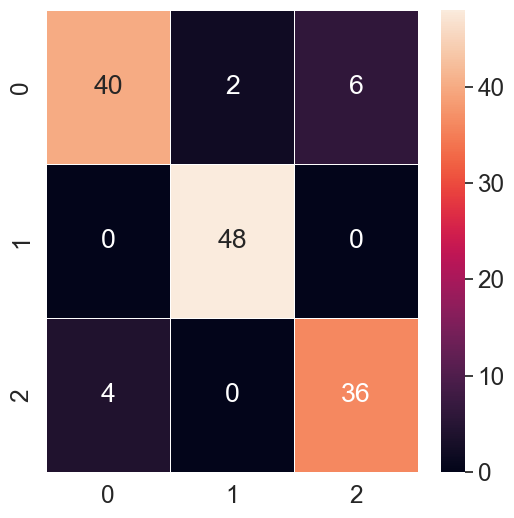

In [111]:
fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

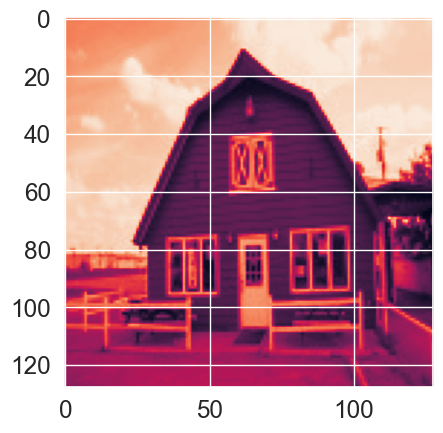

In [77]:
n=random.randint(0, x_test.shape[0]-1)
img = x_test[n]
plt.imshow(img)

In [78]:
input_img = np.expand_dims(img, axis=0)
input_img_features=feature_extractor(input_img)
input_img_features = np.expand_dims(input_img_features, axis=0)
input_img_for_RF = np.reshape(input_img_features, (input_img.shape[0], -1))

In [79]:
#Predict
img_prediction = lgb_model.predict(input_img_for_RF)
img_prediction=np.argmax(img_prediction, axis=1)
img_prediction = le.inverse_transform([img_prediction])
print("The prediction for this image is: ", img_prediction)
print("The actual label for this image is: ", test_labels[n])

The prediction for this image is:  ['barn']
The actual label for this image is:  barn


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


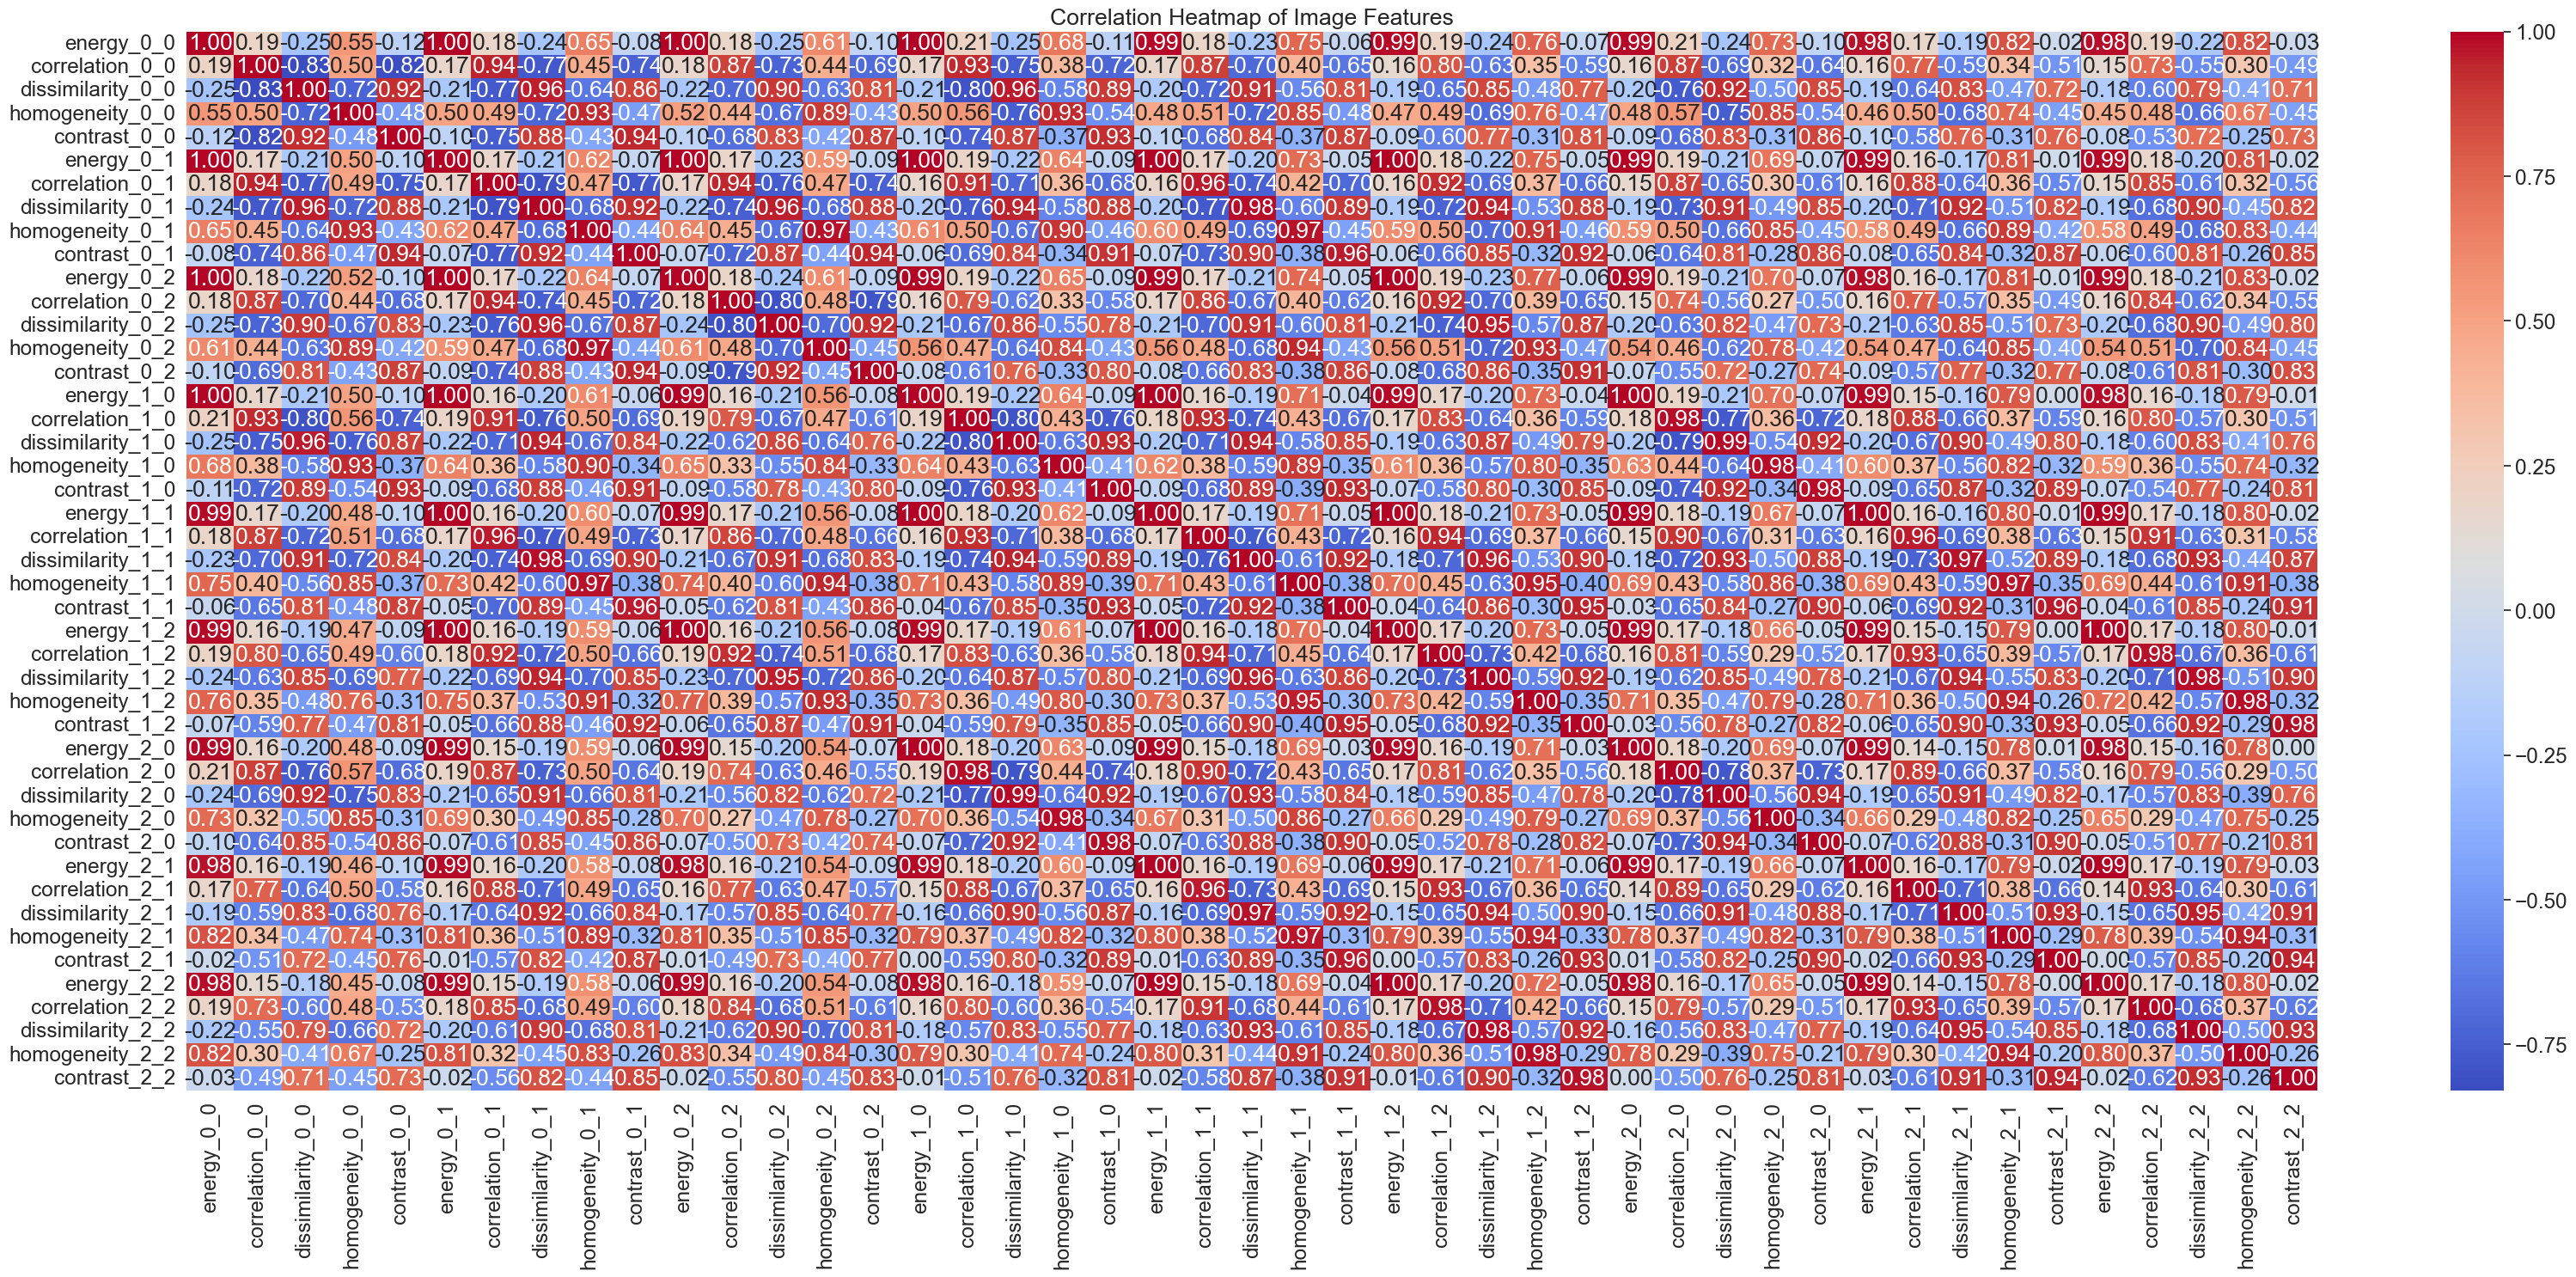

In [80]:
plt.figure(figsize=(40,16))
sns.heatmap(image_feature.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Image Features')
plt.show()

# Gabor & GLCM 

In [143]:
SIZE = 128

def gabor_features(img):
    # Define parameters for Gabor filter
    frequencies = [0.1, 0.5]
    thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    feature_vector = []
    
    for freq in frequencies:
        for theta in thetas:
            gabor_filter_real = cv.getGaborKernel((5, 5), 4.0, theta, freq, 0.5, 0, ktype=cv.CV_32F)
            gabor_filter_imag = cv.getGaborKernel((5, 5), 4.0, theta, freq, 0.5, np.pi/2, ktype=cv.CV_32F)
            real_part = cv.filter2D(img, cv.CV_8UC3, gabor_filter_real)
            imag_part = cv.filter2D(img, cv.CV_8UC3, gabor_filter_imag)
            feature_vector.append(np.mean(real_part))
            feature_vector.append(np.mean(imag_part))
    
    return feature_vector



In [144]:
# Extract features for GLCM and Gabor
glcm_train_features = feature_extractor(train_img)
glcm_test_features = feature_extractor(test_img)

gabor_train_features = [gabor_features(img) for img in train_img]
gabor_test_features = [gabor_features(img) for img in test_img]

# Combine features
X_train = np.hstack((glcm_train_features, gabor_train_features))
X_test = np.hstack((glcm_test_features, gabor_test_features))
X_train.shape

(4254, 61)

In [146]:
X_train = np.array(gabor_train_features)
X_test = np.array(gabor_test_features)

In [147]:
d_train = lgb.Dataset(X_train, label=y_train)
lgb_model = lgb.train(lgbm_params, d_train, 100)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3057
[LightGBM] [Info] Number of data points in the train set: 4254, number of used features: 12
[LightGBM] [Info] Start training from score -1.087392
[LightGBM] [Info] Start training from score -1.003174
[LightGBM] [Info] Start training from score -1.216748
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

In [148]:
test_prediction = lgb_model.predict(X_test)
test_prediction = np.argmax(test_prediction, axis=1)
test_prediction = le.inverse_transform(test_prediction)

In [149]:
accuracy = accuracy_score(test_labels, test_prediction)
print("Accuracy (Gabor):", accuracy * 100)

Accuracy (Gabor): 83.82352941176471


In [134]:
# Encode labels
le = preprocessing.LabelEncoder()
le.fit(train_labels)
y_train = le.transform(train_labels)
y_test = le.transform(test_labels)

In [135]:
d_train = lgb.Dataset(X_train, label=y_train)
lgb_model = lgb.train(lgbm_params, d_train, 100)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14532
[LightGBM] [Info] Number of data points in the train set: 4254, number of used features: 57
[LightGBM] [Info] Start training from score -1.087392
[LightGBM] [Info] Start training from score -1.003174
[LightGBM] [Info] Start training from score -1.216748
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [136]:
# Make predictions
test_prediction = lgb_model.predict(X_test)
test_prediction = np.argmax(test_prediction, axis=1)
test_prediction = le.inverse_transform(test_prediction)

In [137]:
accuracy = accuracy_score(test_labels, test_prediction)
print("Accuracy (GLCM + Gabor):", accuracy * 100)

Accuracy (GLCM + Gabor): 89.70588235294117


### GLCM

<Axes: >

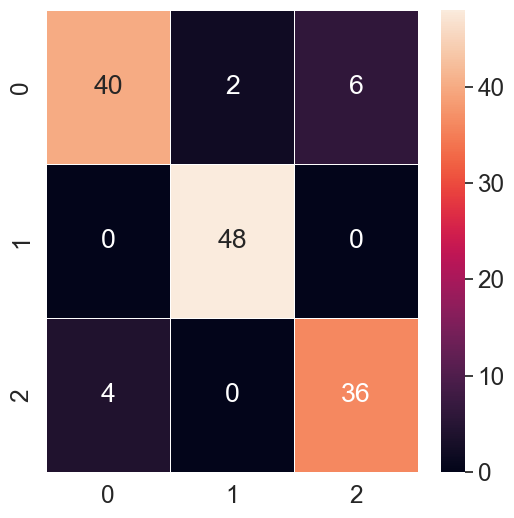

In [112]:

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

Observation: Glcm has 91.7% accuracy

### Gabor

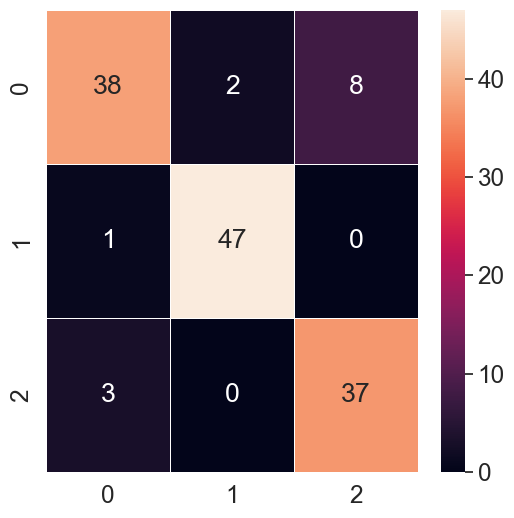

In [138]:
cm = confusion_matrix(test_labels, test_prediction)
fig, ax = plt.subplots(figsize=(6, 6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)
plt.show()

Observation: Gabor has 83.8% accuracy

### GLCM+Gabor

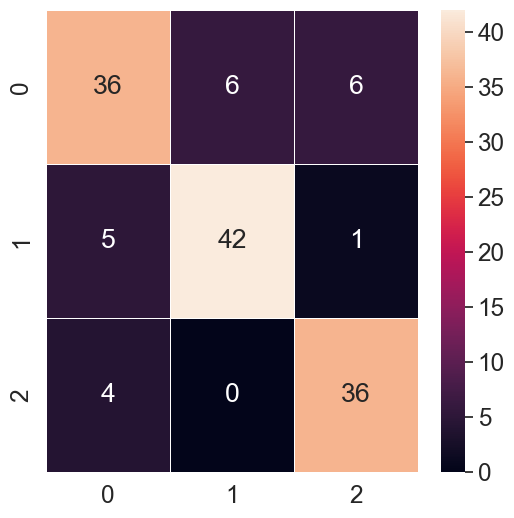

In [150]:
cm = confusion_matrix(test_labels, test_prediction)
fig, ax = plt.subplots(figsize=(6, 6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)
plt.show()

Observation: Glcm + Gabor has 89.7% accuracy